<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:19:38] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


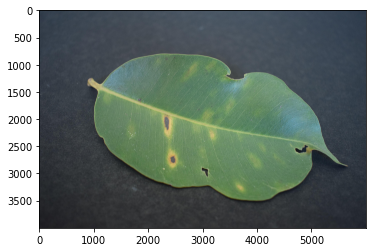

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

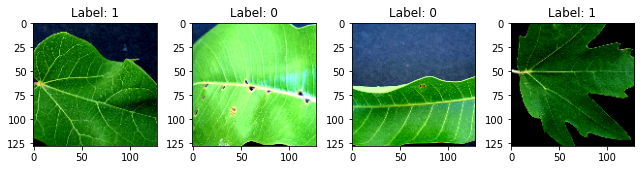

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:19:44] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:19:46] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2185135560702212 samples/sec                   batch loss = 0.5002690553665161 | accuracy = 0.75


Epoch[1] Batch[10] Speed: 1.2610424162395097 samples/sec                   batch loss = 0.40654057264328003 | accuracy = 0.65


Epoch[1] Batch[15] Speed: 1.2533685012088647 samples/sec                   batch loss = 0.6766814589500427 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.2622277728666278 samples/sec                   batch loss = 1.795369029045105 | accuracy = 0.5375


Epoch[1] Batch[25] Speed: 1.2697549284202565 samples/sec                   batch loss = 1.5898538827896118 | accuracy = 0.53


Epoch[1] Batch[30] Speed: 1.2656226036970006 samples/sec                   batch loss = 0.3227318227291107 | accuracy = 0.55


Epoch[1] Batch[35] Speed: 1.2503537977973576 samples/sec                   batch loss = 0.39944034814834595 | accuracy = 0.5785714285714286


Epoch[1] Batch[40] Speed: 1.2623601655215255 samples/sec                   batch loss = 0.5068273544311523 | accuracy = 0.60625


Epoch[1] Batch[45] Speed: 1.2629138752303526 samples/sec                   batch loss = 0.7099721431732178 | accuracy = 0.6


Epoch[1] Batch[50] Speed: 1.263602532113295 samples/sec                   batch loss = 1.5367120504379272 | accuracy = 0.59


Epoch[1] Batch[55] Speed: 1.2596021939634772 samples/sec                   batch loss = 0.5891604423522949 | accuracy = 0.5954545454545455


Epoch[1] Batch[60] Speed: 1.2560787115554983 samples/sec                   batch loss = 1.2508817911148071 | accuracy = 0.5916666666666667


Epoch[1] Batch[65] Speed: 1.253916411033545 samples/sec                   batch loss = 0.271096408367157 | accuracy = 0.6076923076923076


Epoch[1] Batch[70] Speed: 1.259084549174435 samples/sec                   batch loss = 0.45418447256088257 | accuracy = 0.625


Epoch[1] Batch[75] Speed: 1.2610554019146119 samples/sec                   batch loss = 0.5859264135360718 | accuracy = 0.6233333333333333


Epoch[1] Batch[80] Speed: 1.2571792877789238 samples/sec                   batch loss = 0.5773071050643921 | accuracy = 0.634375


Epoch[1] Batch[85] Speed: 1.2649224929230243 samples/sec                   batch loss = 1.3158777952194214 | accuracy = 0.6352941176470588


Epoch[1] Batch[90] Speed: 1.260394988294712 samples/sec                   batch loss = 0.7356507778167725 | accuracy = 0.6472222222222223


Epoch[1] Batch[95] Speed: 1.2661723951104353 samples/sec                   batch loss = 0.9224441051483154 | accuracy = 0.6447368421052632


Epoch[1] Batch[100] Speed: 1.2599327033225238 samples/sec                   batch loss = 0.3840414583683014 | accuracy = 0.6525


Epoch[1] Batch[105] Speed: 1.2659502623849421 samples/sec                   batch loss = 0.38958796858787537 | accuracy = 0.6547619047619048


Epoch[1] Batch[110] Speed: 1.2593542839187701 samples/sec                   batch loss = 0.5337260961532593 | accuracy = 0.6545454545454545


Epoch[1] Batch[115] Speed: 1.2630320539661648 samples/sec                   batch loss = 0.7725213766098022 | accuracy = 0.6565217391304348


Epoch[1] Batch[120] Speed: 1.2582803787887424 samples/sec                   batch loss = 0.7623258829116821 | accuracy = 0.65625


Epoch[1] Batch[125] Speed: 1.2607324507994166 samples/sec                   batch loss = 0.5822657346725464 | accuracy = 0.658


Epoch[1] Batch[130] Speed: 1.254560951195762 samples/sec                   batch loss = 0.5013565421104431 | accuracy = 0.6557692307692308


Epoch[1] Batch[135] Speed: 1.2631934326532765 samples/sec                   batch loss = 0.3339131474494934 | accuracy = 0.6592592592592592


Epoch[1] Batch[140] Speed: 1.2605014262258156 samples/sec                   batch loss = 0.7891743779182434 | accuracy = 0.6553571428571429


Epoch[1] Batch[145] Speed: 1.2567548486164377 samples/sec                   batch loss = 0.32221776247024536 | accuracy = 0.656896551724138


Epoch[1] Batch[150] Speed: 1.2639665678856276 samples/sec                   batch loss = 0.4935234785079956 | accuracy = 0.655


Epoch[1] Batch[155] Speed: 1.2556820809880191 samples/sec                   batch loss = 0.287732869386673 | accuracy = 0.6580645161290323


Epoch[1] Batch[160] Speed: 1.26039953331936 samples/sec                   batch loss = 0.26534944772720337 | accuracy = 0.659375


Epoch[1] Batch[165] Speed: 1.2588272086254326 samples/sec                   batch loss = 0.31654092669487 | accuracy = 0.6651515151515152


Epoch[1] Batch[170] Speed: 1.2629136850973512 samples/sec                   batch loss = 0.25232672691345215 | accuracy = 0.6661764705882353


Epoch[1] Batch[175] Speed: 1.2578508578609344 samples/sec                   batch loss = 0.2901096045970917 | accuracy = 0.6657142857142857


Epoch[1] Batch[180] Speed: 1.262008066156444 samples/sec                   batch loss = 0.22514747083187103 | accuracy = 0.6722222222222223


Epoch[1] Batch[185] Speed: 1.2589385776901127 samples/sec                   batch loss = 0.4274744987487793 | accuracy = 0.6756756756756757


Epoch[1] Batch[190] Speed: 1.258829947746887 samples/sec                   batch loss = 0.7304383516311646 | accuracy = 0.6723684210526316


Epoch[1] Batch[195] Speed: 1.2597832242616542 samples/sec                   batch loss = 0.9579361081123352 | accuracy = 0.6717948717948717


Epoch[1] Batch[200] Speed: 1.2570935669587584 samples/sec                   batch loss = 0.6058701276779175 | accuracy = 0.67375


Epoch[1] Batch[205] Speed: 1.2569568146455723 samples/sec                   batch loss = 1.233305811882019 | accuracy = 0.6719512195121952


Epoch[1] Batch[210] Speed: 1.2580078022923387 samples/sec                   batch loss = 0.41229456663131714 | accuracy = 0.675


Epoch[1] Batch[215] Speed: 1.2600626275433662 samples/sec                   batch loss = 0.5376790165901184 | accuracy = 0.6779069767441861


Epoch[1] Batch[220] Speed: 1.2545398435961825 samples/sec                   batch loss = 0.31693246960639954 | accuracy = 0.678409090909091


Epoch[1] Batch[225] Speed: 1.258864801746916 samples/sec                   batch loss = 0.3757062256336212 | accuracy = 0.6744444444444444


Epoch[1] Batch[230] Speed: 1.2573812017897348 samples/sec                   batch loss = 0.5861676931381226 | accuracy = 0.6760869565217391


Epoch[1] Batch[235] Speed: 1.2623969250793587 samples/sec                   batch loss = 0.6425009965896606 | accuracy = 0.6691489361702128


Epoch[1] Batch[240] Speed: 1.253466731895607 samples/sec                   batch loss = 0.8733154535293579 | accuracy = 0.6677083333333333


Epoch[1] Batch[245] Speed: 1.2598403627019965 samples/sec                   batch loss = 0.48352643847465515 | accuracy = 0.6673469387755102


Epoch[1] Batch[250] Speed: 1.257512579648496 samples/sec                   batch loss = 0.643826961517334 | accuracy = 0.668


Epoch[1] Batch[255] Speed: 1.26911474996144 samples/sec                   batch loss = 0.9086953401565552 | accuracy = 0.6666666666666666


Epoch[1] Batch[260] Speed: 1.2631780252468217 samples/sec                   batch loss = 1.2129912376403809 | accuracy = 0.6653846153846154


Epoch[1] Batch[265] Speed: 1.2584504569053214 samples/sec                   batch loss = 0.40212714672088623 | accuracy = 0.6650943396226415


Epoch[1] Batch[270] Speed: 1.2626232287321995 samples/sec                   batch loss = 0.7369132041931152 | accuracy = 0.6666666666666666


Epoch[1] Batch[275] Speed: 1.2602352704340534 samples/sec                   batch loss = 0.5061392188072205 | accuracy = 0.67


Epoch[1] Batch[280] Speed: 1.2602959527720745 samples/sec                   batch loss = 0.4264032244682312 | accuracy = 0.6705357142857142


Epoch[1] Batch[285] Speed: 1.2649434744851435 samples/sec                   batch loss = 0.5960085988044739 | accuracy = 0.6728070175438596


Epoch[1] Batch[290] Speed: 1.2594925039502678 samples/sec                   batch loss = 0.4702608585357666 | accuracy = 0.6741379310344827


Epoch[1] Batch[295] Speed: 1.256609228547589 samples/sec                   batch loss = 1.0401115417480469 | accuracy = 0.6754237288135593


Epoch[1] Batch[300] Speed: 1.2586301176249235 samples/sec                   batch loss = 1.0151609182357788 | accuracy = 0.6741666666666667


Epoch[1] Batch[305] Speed: 1.2527293011306078 samples/sec                   batch loss = 0.5204421877861023 | accuracy = 0.6745901639344263


Epoch[1] Batch[310] Speed: 1.2566780338249297 samples/sec                   batch loss = 0.5872285962104797 | accuracy = 0.675


Epoch[1] Batch[315] Speed: 1.2583382303913608 samples/sec                   batch loss = 0.6495647430419922 | accuracy = 0.6714285714285714


Epoch[1] Batch[320] Speed: 1.2541136221133782 samples/sec                   batch loss = 0.6628488302230835 | accuracy = 0.67109375


Epoch[1] Batch[325] Speed: 1.2589937499873367 samples/sec                   batch loss = 0.8916351199150085 | accuracy = 0.6715384615384615


Epoch[1] Batch[330] Speed: 1.2587516513540653 samples/sec                   batch loss = 0.8382106423377991 | accuracy = 0.668939393939394


Epoch[1] Batch[335] Speed: 1.2647583839012813 samples/sec                   batch loss = 0.47846779227256775 | accuracy = 0.6708955223880597


Epoch[1] Batch[340] Speed: 1.2610939813736028 samples/sec                   batch loss = 0.46171092987060547 | accuracy = 0.6691176470588235


Epoch[1] Batch[345] Speed: 1.260477182553844 samples/sec                   batch loss = 0.39396992325782776 | accuracy = 0.6695652173913044


Epoch[1] Batch[350] Speed: 1.2545278360342684 samples/sec                   batch loss = 0.5184661746025085 | accuracy = 0.6714285714285714


Epoch[1] Batch[355] Speed: 1.2558010720542236 samples/sec                   batch loss = 0.511455774307251 | accuracy = 0.6725352112676056


Epoch[1] Batch[360] Speed: 1.257370741748503 samples/sec                   batch loss = 0.4273442327976227 | accuracy = 0.6736111111111112


Epoch[1] Batch[365] Speed: 1.2606470025698775 samples/sec                   batch loss = 0.4980824589729309 | accuracy = 0.673972602739726


Epoch[1] Batch[370] Speed: 1.258892950830497 samples/sec                   batch loss = 0.4904758930206299 | accuracy = 0.6743243243243243


Epoch[1] Batch[375] Speed: 1.2596263094160078 samples/sec                   batch loss = 0.4605855643749237 | accuracy = 0.6766666666666666


Epoch[1] Batch[380] Speed: 1.262768820391004 samples/sec                   batch loss = 0.6174347996711731 | accuracy = 0.6782894736842106


Epoch[1] Batch[385] Speed: 1.25412159059471 samples/sec                   batch loss = 0.6678872108459473 | accuracy = 0.6785714285714286


Epoch[1] Batch[390] Speed: 1.262044805210778 samples/sec                   batch loss = 0.7282577753067017 | accuracy = 0.6788461538461539


Epoch[1] Batch[395] Speed: 1.2593689364515919 samples/sec                   batch loss = 0.6144455671310425 | accuracy = 0.6772151898734177


Epoch[1] Batch[400] Speed: 1.2562485712293954 samples/sec                   batch loss = 0.46601852774620056 | accuracy = 0.678125


Epoch[1] Batch[405] Speed: 1.256545983283817 samples/sec                   batch loss = 0.42992547154426575 | accuracy = 0.6796296296296296


Epoch[1] Batch[410] Speed: 1.2555410315359978 samples/sec                   batch loss = 0.31757068634033203 | accuracy = 0.6823170731707318


Epoch[1] Batch[415] Speed: 1.2622523688275453 samples/sec                   batch loss = 0.24249210953712463 | accuracy = 0.6831325301204819


Epoch[1] Batch[420] Speed: 1.2581744099603955 samples/sec                   batch loss = 0.4059433341026306 | accuracy = 0.6839285714285714


Epoch[1] Batch[425] Speed: 1.2581533692983933 samples/sec                   batch loss = 0.45440906286239624 | accuracy = 0.6835294117647058


Epoch[1] Batch[430] Speed: 1.2611191967427358 samples/sec                   batch loss = 0.3754342496395111 | accuracy = 0.6837209302325581


Epoch[1] Batch[435] Speed: 1.2648676580361187 samples/sec                   batch loss = 0.765158474445343 | accuracy = 0.6833333333333333


Epoch[1] Batch[440] Speed: 1.2595842261873926 samples/sec                   batch loss = 0.2934872806072235 | accuracy = 0.6840909090909091


Epoch[1] Batch[445] Speed: 1.2587148204728302 samples/sec                   batch loss = 0.35752612352371216 | accuracy = 0.6853932584269663


Epoch[1] Batch[450] Speed: 1.2554576008085352 samples/sec                   batch loss = 0.3074498772621155 | accuracy = 0.6844444444444444


Epoch[1] Batch[455] Speed: 1.2564243105275947 samples/sec                   batch loss = 0.5026178956031799 | accuracy = 0.6851648351648352


Epoch[1] Batch[460] Speed: 1.2609237566190692 samples/sec                   batch loss = 0.667286217212677 | accuracy = 0.6842391304347826


Epoch[1] Batch[465] Speed: 1.2569655726829092 samples/sec                   batch loss = 0.24176742136478424 | accuracy = 0.6854838709677419


Epoch[1] Batch[470] Speed: 1.2613568964027846 samples/sec                   batch loss = 0.6268742680549622 | accuracy = 0.6872340425531915


Epoch[1] Batch[475] Speed: 1.257698289583833 samples/sec                   batch loss = 0.48596131801605225 | accuracy = 0.6863157894736842


Epoch[1] Batch[480] Speed: 1.258491709191567 samples/sec                   batch loss = 0.5991879105567932 | accuracy = 0.6859375


Epoch[1] Batch[485] Speed: 1.2604028474204971 samples/sec                   batch loss = 0.8123201131820679 | accuracy = 0.6845360824742268


Epoch[1] Batch[490] Speed: 1.260848421246762 samples/sec                   batch loss = 0.2823322117328644 | accuracy = 0.6846938775510204


Epoch[1] Batch[495] Speed: 1.2610978678873233 samples/sec                   batch loss = 1.0603801012039185 | accuracy = 0.6853535353535354


Epoch[1] Batch[500] Speed: 1.2627803209017898 samples/sec                   batch loss = 2.4570746421813965 | accuracy = 0.685


Epoch[1] Batch[505] Speed: 1.2562026688478403 samples/sec                   batch loss = 0.4252277612686157 | accuracy = 0.6846534653465347


Epoch[1] Batch[510] Speed: 1.261686239960955 samples/sec                   batch loss = 0.17350807785987854 | accuracy = 0.6852941176470588


Epoch[1] Batch[515] Speed: 1.2572341175539605 samples/sec                   batch loss = 0.9212678074836731 | accuracy = 0.6854368932038835


Epoch[1] Batch[520] Speed: 1.262876134951749 samples/sec                   batch loss = 0.7053326964378357 | accuracy = 0.6846153846153846


Epoch[1] Batch[525] Speed: 1.2654876167932276 samples/sec                   batch loss = 0.3658592998981476 | accuracy = 0.6852380952380952


Epoch[1] Batch[530] Speed: 1.264426958257641 samples/sec                   batch loss = 0.3170882761478424 | accuracy = 0.6867924528301886


Epoch[1] Batch[535] Speed: 1.2648388597040585 samples/sec                   batch loss = 0.23751069605350494 | accuracy = 0.685981308411215


Epoch[1] Batch[540] Speed: 1.2666680558537777 samples/sec                   batch loss = 0.8635203838348389 | accuracy = 0.6842592592592592


Epoch[1] Batch[545] Speed: 1.2661056993342183 samples/sec                   batch loss = 0.17716866731643677 | accuracy = 0.6871559633027523


Epoch[1] Batch[550] Speed: 1.2578923537819247 samples/sec                   batch loss = 0.4288843274116516 | accuracy = 0.6877272727272727


Epoch[1] Batch[555] Speed: 1.2654227111375904 samples/sec                   batch loss = 0.6991612315177917 | accuracy = 0.6878378378378378


Epoch[1] Batch[560] Speed: 1.2586468306620036 samples/sec                   batch loss = 0.33622005581855774 | accuracy = 0.6875


Epoch[1] Batch[565] Speed: 1.2641358054830705 samples/sec                   batch loss = 0.1322188675403595 | accuracy = 0.6867256637168142


Epoch[1] Batch[570] Speed: 1.2616766569736575 samples/sec                   batch loss = 0.22327177226543427 | accuracy = 0.6881578947368421


Epoch[1] Batch[575] Speed: 1.2634249694351787 samples/sec                   batch loss = 0.4820139408111572 | accuracy = 0.6882608695652174


Epoch[1] Batch[580] Speed: 1.2626383375322898 samples/sec                   batch loss = 0.3982130289077759 | accuracy = 0.6883620689655172


Epoch[1] Batch[585] Speed: 1.2644436350059394 samples/sec                   batch loss = 0.31631362438201904 | accuracy = 0.6888888888888889


Epoch[1] Batch[590] Speed: 1.257585537315374 samples/sec                   batch loss = 1.1322624683380127 | accuracy = 0.6885593220338984


Epoch[1] Batch[595] Speed: 1.2623141003643035 samples/sec                   batch loss = 0.6302905082702637 | accuracy = 0.6899159663865546


Epoch[1] Batch[600] Speed: 1.2606527808543746 samples/sec                   batch loss = 0.2715494632720947 | accuracy = 0.6891666666666667


Epoch[1] Batch[605] Speed: 1.2649058035411025 samples/sec                   batch loss = 0.5061793923377991 | accuracy = 0.6896694214876034


Epoch[1] Batch[610] Speed: 1.2639276220340798 samples/sec                   batch loss = 0.4912773072719574 | accuracy = 0.690983606557377


Epoch[1] Batch[615] Speed: 1.2652523654643115 samples/sec                   batch loss = 0.6326472163200378 | accuracy = 0.6910569105691057


Epoch[1] Batch[620] Speed: 1.25917451091941 samples/sec                   batch loss = 0.5708719491958618 | accuracy = 0.6915322580645161


Epoch[1] Batch[625] Speed: 1.2591046760535813 samples/sec                   batch loss = 0.38786840438842773 | accuracy = 0.6916


Epoch[1] Batch[630] Speed: 1.2553282487345119 samples/sec                   batch loss = 0.7178231477737427 | accuracy = 0.6912698412698413


Epoch[1] Batch[635] Speed: 1.2614421563623777 samples/sec                   batch loss = 0.3334495425224304 | accuracy = 0.6905511811023622


Epoch[1] Batch[640] Speed: 1.2691767705135988 samples/sec                   batch loss = 0.9180316925048828 | accuracy = 0.6890625


Epoch[1] Batch[645] Speed: 1.2622510392916377 samples/sec                   batch loss = 0.5528863668441772 | accuracy = 0.6891472868217055


Epoch[1] Batch[650] Speed: 1.269780010815356 samples/sec                   batch loss = 0.20797599852085114 | accuracy = 0.6903846153846154


Epoch[1] Batch[655] Speed: 1.261862270224736 samples/sec                   batch loss = 0.5663366913795471 | accuracy = 0.6896946564885497


Epoch[1] Batch[660] Speed: 1.2619804420748506 samples/sec                   batch loss = 1.109658122062683 | accuracy = 0.6909090909090909


Epoch[1] Batch[665] Speed: 1.2621052821626957 samples/sec                   batch loss = 0.7763071060180664 | accuracy = 0.6909774436090226


Epoch[1] Batch[670] Speed: 1.2623328109608534 samples/sec                   batch loss = 0.43040356040000916 | accuracy = 0.691044776119403


Epoch[1] Batch[675] Speed: 1.2574406671327514 samples/sec                   batch loss = 0.48394861817359924 | accuracy = 0.6907407407407408


Epoch[1] Batch[680] Speed: 1.2627612168625413 samples/sec                   batch loss = 0.733742892742157 | accuracy = 0.6904411764705882


Epoch[1] Batch[685] Speed: 1.252500732550826 samples/sec                   batch loss = 1.230961799621582 | accuracy = 0.6908759124087591


Epoch[1] Batch[690] Speed: 1.2585447653065902 samples/sec                   batch loss = 0.19316372275352478 | accuracy = 0.6923913043478261


Epoch[1] Batch[695] Speed: 1.2566944126619115 samples/sec                   batch loss = 0.2008579969406128 | accuracy = 0.6928057553956835


Epoch[1] Batch[700] Speed: 1.257112028916876 samples/sec                   batch loss = 0.5336639285087585 | accuracy = 0.6932142857142857


Epoch[1] Batch[705] Speed: 1.2628155841043394 samples/sec                   batch loss = 0.26124054193496704 | accuracy = 0.6936170212765957


Epoch[1] Batch[710] Speed: 1.2553255248307256 samples/sec                   batch loss = 0.3038288652896881 | accuracy = 0.6940140845070423


Epoch[1] Batch[715] Speed: 1.264747133360919 samples/sec                   batch loss = 0.30651095509529114 | accuracy = 0.6940559440559441


Epoch[1] Batch[720] Speed: 1.257953470941889 samples/sec                   batch loss = 0.6015282869338989 | accuracy = 0.6944444444444444


Epoch[1] Batch[725] Speed: 1.256713333574031 samples/sec                   batch loss = 0.6683558225631714 | accuracy = 0.6944827586206896


Epoch[1] Batch[730] Speed: 1.2589834520511103 samples/sec                   batch loss = 0.7504937648773193 | accuracy = 0.6948630136986301


Epoch[1] Batch[735] Speed: 1.2650662305711682 samples/sec                   batch loss = 0.4000275731086731 | accuracy = 0.6955782312925171


Epoch[1] Batch[740] Speed: 1.260015310449671 samples/sec                   batch loss = 0.3065093755722046 | accuracy = 0.6956081081081081


Epoch[1] Batch[745] Speed: 1.2646828756363944 samples/sec                   batch loss = 0.3419961631298065 | accuracy = 0.6959731543624161


Epoch[1] Batch[750] Speed: 1.2638705883088541 samples/sec                   batch loss = 0.789376974105835 | accuracy = 0.6963333333333334


Epoch[1] Batch[755] Speed: 1.257862834811605 samples/sec                   batch loss = 0.921830415725708 | accuracy = 0.695364238410596


Epoch[1] Batch[760] Speed: 1.2595324062096993 samples/sec                   batch loss = 0.4626237154006958 | accuracy = 0.6960526315789474


Epoch[1] Batch[765] Speed: 1.2633397266320738 samples/sec                   batch loss = 0.4537402391433716 | accuracy = 0.6954248366013072


Epoch[1] Batch[770] Speed: 1.2635283988604367 samples/sec                   batch loss = 0.6031314134597778 | accuracy = 0.6948051948051948


Epoch[1] Batch[775] Speed: 1.267042472299804 samples/sec                   batch loss = 0.6482226848602295 | accuracy = 0.6941935483870968


Epoch[1] Batch[780] Speed: 1.269922547605776 samples/sec                   batch loss = 0.3875423073768616 | accuracy = 0.6951923076923077


Epoch[1] Batch[785] Speed: 1.271021240334696 samples/sec                   batch loss = 0.3213003873825073 | accuracy = 0.695859872611465


[Epoch 1] training: accuracy=0.695748730964467
[Epoch 1] time cost: 651.305732011795
[Epoch 1] validation: validation accuracy=0.7511111111111111


Epoch[2] Batch[5] Speed: 1.2617362446423714 samples/sec                   batch loss = 0.5676688551902771 | accuracy = 0.65


Epoch[2] Batch[10] Speed: 1.2624362516276881 samples/sec                   batch loss = 0.4984108507633209 | accuracy = 0.65


Epoch[2] Batch[15] Speed: 1.2567174755412536 samples/sec                   batch loss = 0.4166700541973114 | accuracy = 0.65


Epoch[2] Batch[20] Speed: 1.2650702369987374 samples/sec                   batch loss = 0.43069204688072205 | accuracy = 0.65


Epoch[2] Batch[25] Speed: 1.2649021796192255 samples/sec                   batch loss = 0.4916456937789917 | accuracy = 0.67


Epoch[2] Batch[30] Speed: 1.262644609215885 samples/sec                   batch loss = 0.3363245725631714 | accuracy = 0.6833333333333333


Epoch[2] Batch[35] Speed: 1.2604484891003074 samples/sec                   batch loss = 0.7620038390159607 | accuracy = 0.6785714285714286


Epoch[2] Batch[40] Speed: 1.2549609102325159 samples/sec                   batch loss = 0.6430190801620483 | accuracy = 0.6875


Epoch[2] Batch[45] Speed: 1.2513474728730276 samples/sec                   batch loss = 0.13187460601329803 | accuracy = 0.7055555555555556


Epoch[2] Batch[50] Speed: 1.2602278867105996 samples/sec                   batch loss = 0.6366868019104004 | accuracy = 0.7


Epoch[2] Batch[55] Speed: 1.2636641102471544 samples/sec                   batch loss = 0.45507049560546875 | accuracy = 0.7


Epoch[2] Batch[60] Speed: 1.2619999022126274 samples/sec                   batch loss = 0.41829586029052734 | accuracy = 0.6958333333333333


Epoch[2] Batch[65] Speed: 1.2670974002218014 samples/sec                   batch loss = 0.24712993204593658 | accuracy = 0.7076923076923077


Epoch[2] Batch[70] Speed: 1.2669982654800318 samples/sec                   batch loss = 0.31524786353111267 | accuracy = 0.7142857142857143


Epoch[2] Batch[75] Speed: 1.2639720909635332 samples/sec                   batch loss = 0.2642218768596649 | accuracy = 0.7266666666666667


Epoch[2] Batch[80] Speed: 1.2587505180640415 samples/sec                   batch loss = 0.7473523616790771 | accuracy = 0.73125


Epoch[2] Batch[85] Speed: 1.2582212114451135 samples/sec                   batch loss = 0.5722618699073792 | accuracy = 0.7205882352941176


Epoch[2] Batch[90] Speed: 1.2635571375485906 samples/sec                   batch loss = 0.5080494284629822 | accuracy = 0.725


Epoch[2] Batch[95] Speed: 1.2636187112580675 samples/sec                   batch loss = 0.39120668172836304 | accuracy = 0.7289473684210527


Epoch[2] Batch[100] Speed: 1.2635626570489424 samples/sec                   batch loss = 0.17582343518733978 | accuracy = 0.74


Epoch[2] Batch[105] Speed: 1.2648104440922459 samples/sec                   batch loss = 0.5500785112380981 | accuracy = 0.7452380952380953


Epoch[2] Batch[110] Speed: 1.2530775515581707 samples/sec                   batch loss = 0.21988961100578308 | accuracy = 0.740909090909091


Epoch[2] Batch[115] Speed: 1.2673637820543084 samples/sec                   batch loss = 0.9856860637664795 | accuracy = 0.7369565217391304


Epoch[2] Batch[120] Speed: 1.2645559047940425 samples/sec                   batch loss = 0.479533314704895 | accuracy = 0.7291666666666666


Epoch[2] Batch[125] Speed: 1.2661709617462353 samples/sec                   batch loss = 0.24539080262184143 | accuracy = 0.732


Epoch[2] Batch[130] Speed: 1.2637466362604066 samples/sec                   batch loss = 0.23616550862789154 | accuracy = 0.7269230769230769


Epoch[2] Batch[135] Speed: 1.2620474634165533 samples/sec                   batch loss = 0.6238618493080139 | accuracy = 0.725925925925926


Epoch[2] Batch[140] Speed: 1.2577784351764394 samples/sec                   batch loss = 0.3678514063358307 | accuracy = 0.7285714285714285


Epoch[2] Batch[145] Speed: 1.2699357168133554 samples/sec                   batch loss = 0.28910237550735474 | accuracy = 0.7344827586206897


Epoch[2] Batch[150] Speed: 1.2646721984275813 samples/sec                   batch loss = 0.3847619295120239 | accuracy = 0.7316666666666667


Epoch[2] Batch[155] Speed: 1.2671872664463146 samples/sec                   batch loss = 0.4860207438468933 | accuracy = 0.7290322580645161


Epoch[2] Batch[160] Speed: 1.2638978191282073 samples/sec                   batch loss = 0.47122737765312195 | accuracy = 0.73125


Epoch[2] Batch[165] Speed: 1.263969329418547 samples/sec                   batch loss = 0.269969642162323 | accuracy = 0.7303030303030303


Epoch[2] Batch[170] Speed: 1.263582737017376 samples/sec                   batch loss = 0.942396879196167 | accuracy = 0.725


Epoch[2] Batch[175] Speed: 1.2678415971832622 samples/sec                   batch loss = 0.33250051736831665 | accuracy = 0.7271428571428571


Epoch[2] Batch[180] Speed: 1.2640396097311941 samples/sec                   batch loss = 0.33431610465049744 | accuracy = 0.7291666666666666


Epoch[2] Batch[185] Speed: 1.2661418173780161 samples/sec                   batch loss = 0.46862733364105225 | accuracy = 0.731081081081081


Epoch[2] Batch[190] Speed: 1.2618787844782107 samples/sec                   batch loss = 0.621971070766449 | accuracy = 0.7315789473684211


Epoch[2] Batch[195] Speed: 1.2659642090711805 samples/sec                   batch loss = 0.38540154695510864 | accuracy = 0.7307692307692307


Epoch[2] Batch[200] Speed: 1.2654554494816956 samples/sec                   batch loss = 0.48594099283218384 | accuracy = 0.7325


Epoch[2] Batch[205] Speed: 1.2644808972159167 samples/sec                   batch loss = 0.18506604433059692 | accuracy = 0.7304878048780488


Epoch[2] Batch[210] Speed: 1.2644650771858676 samples/sec                   batch loss = 0.49807390570640564 | accuracy = 0.7297619047619047


Epoch[2] Batch[215] Speed: 1.267124578864178 samples/sec                   batch loss = 0.8045138120651245 | accuracy = 0.7313953488372092


Epoch[2] Batch[220] Speed: 1.2589651240308937 samples/sec                   batch loss = 0.5833486914634705 | accuracy = 0.7306818181818182


Epoch[2] Batch[225] Speed: 1.260406824364867 samples/sec                   batch loss = 0.43901458382606506 | accuracy = 0.73


Epoch[2] Batch[230] Speed: 1.2660058599085247 samples/sec                   batch loss = 0.752754807472229 | accuracy = 0.7304347826086957


Epoch[2] Batch[235] Speed: 1.2633986152419772 samples/sec                   batch loss = 0.2830083966255188 | accuracy = 0.7287234042553191


Epoch[2] Batch[240] Speed: 1.2568887321304705 samples/sec                   batch loss = 0.4368623197078705 | accuracy = 0.7291666666666666


Epoch[2] Batch[245] Speed: 1.2603411133122746 samples/sec                   batch loss = 0.31852442026138306 | accuracy = 0.7326530612244898


Epoch[2] Batch[250] Speed: 1.2627198742790653 samples/sec                   batch loss = 0.5541824698448181 | accuracy = 0.731


Epoch[2] Batch[255] Speed: 1.2604039836877563 samples/sec                   batch loss = 0.5201759934425354 | accuracy = 0.7274509803921568


Epoch[2] Batch[260] Speed: 1.2584538551607796 samples/sec                   batch loss = 0.626613974571228 | accuracy = 0.7259615384615384


Epoch[2] Batch[265] Speed: 1.2609904762133823 samples/sec                   batch loss = 0.6222688555717468 | accuracy = 0.7273584905660377


Epoch[2] Batch[270] Speed: 1.2592765839269229 samples/sec                   batch loss = 0.36539724469184875 | accuracy = 0.7277777777777777


Epoch[2] Batch[275] Speed: 1.254117090733983 samples/sec                   batch loss = 0.5241835117340088 | accuracy = 0.7263636363636363


Epoch[2] Batch[280] Speed: 1.2630648589043647 samples/sec                   batch loss = 0.25909289717674255 | accuracy = 0.7285714285714285


Epoch[2] Batch[285] Speed: 1.2604421445196228 samples/sec                   batch loss = 0.4477826952934265 | accuracy = 0.7289473684210527


Epoch[2] Batch[290] Speed: 1.258913354980031 samples/sec                   batch loss = 0.5752347707748413 | accuracy = 0.7293103448275862


Epoch[2] Batch[295] Speed: 1.2636812427889297 samples/sec                   batch loss = 0.14997419714927673 | accuracy = 0.7313559322033898


Epoch[2] Batch[300] Speed: 1.2600130393185547 samples/sec                   batch loss = 0.5161932706832886 | accuracy = 0.7325


Epoch[2] Batch[305] Speed: 1.25775976505527 samples/sec                   batch loss = 0.2745133638381958 | accuracy = 0.7311475409836066


Epoch[2] Batch[310] Speed: 1.2646269176259601 samples/sec                   batch loss = 0.6862056255340576 | accuracy = 0.7306451612903225


Epoch[2] Batch[315] Speed: 1.2645831651527968 samples/sec                   batch loss = 0.8244715929031372 | accuracy = 0.7293650793650793


Epoch[2] Batch[320] Speed: 1.2640443715526848 samples/sec                   batch loss = 0.5061160922050476 | accuracy = 0.73203125


Epoch[2] Batch[325] Speed: 1.2676511558393713 samples/sec                   batch loss = 0.5276055932044983 | accuracy = 0.7346153846153847


Epoch[2] Batch[330] Speed: 1.2672507259953232 samples/sec                   batch loss = 0.33785876631736755 | accuracy = 0.7356060606060606


Epoch[2] Batch[335] Speed: 1.2624524009199825 samples/sec                   batch loss = 0.5484859943389893 | accuracy = 0.7365671641791045


Epoch[2] Batch[340] Speed: 1.263876300970898 samples/sec                   batch loss = 0.6438843011856079 | accuracy = 0.7352941176470589


Epoch[2] Batch[345] Speed: 1.2580552517375365 samples/sec                   batch loss = 0.3875105381011963 | accuracy = 0.7355072463768116


Epoch[2] Batch[350] Speed: 1.26057662542189 samples/sec                   batch loss = 0.28347891569137573 | accuracy = 0.7371428571428571


Epoch[2] Batch[355] Speed: 1.2585317368782107 samples/sec                   batch loss = 0.5368446111679077 | accuracy = 0.7366197183098592


Epoch[2] Batch[360] Speed: 1.264313949143839 samples/sec                   batch loss = 1.2107282876968384 | accuracy = 0.7368055555555556


Epoch[2] Batch[365] Speed: 1.262573913844456 samples/sec                   batch loss = 0.3018738329410553 | accuracy = 0.736986301369863


Epoch[2] Batch[370] Speed: 1.26280674435647 samples/sec                   batch loss = 0.45075109601020813 | accuracy = 0.7371621621621621


Epoch[2] Batch[375] Speed: 1.2666100095555084 samples/sec                   batch loss = 0.7397761940956116 | accuracy = 0.7393333333333333


Epoch[2] Batch[380] Speed: 1.2677227083262022 samples/sec                   batch loss = 0.38336339592933655 | accuracy = 0.7407894736842106


Epoch[2] Batch[385] Speed: 1.2624823257007451 samples/sec                   batch loss = 0.7434133887290955 | accuracy = 0.7383116883116884


Epoch[2] Batch[390] Speed: 1.2671241003568703 samples/sec                   batch loss = 0.5874130129814148 | accuracy = 0.7397435897435898


Epoch[2] Batch[395] Speed: 1.2636542116569829 samples/sec                   batch loss = 0.4666886031627655 | accuracy = 0.739240506329114


Epoch[2] Batch[400] Speed: 1.2620770841813458 samples/sec                   batch loss = 1.108878493309021 | accuracy = 0.74125


Epoch[2] Batch[405] Speed: 1.263671248749771 samples/sec                   batch loss = 0.36799144744873047 | accuracy = 0.7407407407407407


Epoch[2] Batch[410] Speed: 1.267007738110297 samples/sec                   batch loss = 0.6493852734565735 | accuracy = 0.7426829268292683


Epoch[2] Batch[415] Speed: 1.2688566521281077 samples/sec                   batch loss = 0.336090087890625 | accuracy = 0.7427710843373494


Epoch[2] Batch[420] Speed: 1.2610713263192201 samples/sec                   batch loss = 0.22643408179283142 | accuracy = 0.7428571428571429


Epoch[2] Batch[425] Speed: 1.2622822841259493 samples/sec                   batch loss = 0.33959972858428955 | accuracy = 0.7405882352941177


Epoch[2] Batch[430] Speed: 1.2578565162344022 samples/sec                   batch loss = 0.5288565754890442 | accuracy = 0.7395348837209302


Epoch[2] Batch[435] Speed: 1.259102691684791 samples/sec                   batch loss = 0.30619198083877563 | accuracy = 0.7396551724137931


Epoch[2] Batch[440] Speed: 1.2564420000753391 samples/sec                   batch loss = 0.4605553448200226 | accuracy = 0.7397727272727272


Epoch[2] Batch[445] Speed: 1.2550941300997502 samples/sec                   batch loss = 0.3247705399990082 | accuracy = 0.7415730337078652


Epoch[2] Batch[450] Speed: 1.2614153157772026 samples/sec                   batch loss = 0.25745144486427307 | accuracy = 0.7422222222222222


Epoch[2] Batch[455] Speed: 1.2594520369424498 samples/sec                   batch loss = 0.39967629313468933 | accuracy = 0.7423076923076923


Epoch[2] Batch[460] Speed: 1.2653557125772115 samples/sec                   batch loss = 0.2296246439218521 | accuracy = 0.7418478260869565


Epoch[2] Batch[465] Speed: 1.2604822016750066 samples/sec                   batch loss = 0.498585969209671 | accuracy = 0.7424731182795699


Epoch[2] Batch[470] Speed: 1.2607167244240376 samples/sec                   batch loss = 0.34147489070892334 | accuracy = 0.7436170212765958


Epoch[2] Batch[475] Speed: 1.2594438114901805 samples/sec                   batch loss = 0.7865329384803772 | accuracy = 0.7410526315789474


Epoch[2] Batch[480] Speed: 1.2591766845239745 samples/sec                   batch loss = 0.6257162690162659 | accuracy = 0.7401041666666667


Epoch[2] Batch[485] Speed: 1.2641389487595933 samples/sec                   batch loss = 0.7072592973709106 | accuracy = 0.7412371134020619


Epoch[2] Batch[490] Speed: 1.2612896639180324 samples/sec                   batch loss = 0.21866963803768158 | accuracy = 0.7418367346938776


Epoch[2] Batch[495] Speed: 1.2561428502867258 samples/sec                   batch loss = 0.4450618624687195 | accuracy = 0.7419191919191919


Epoch[2] Batch[500] Speed: 1.2592023903297023 samples/sec                   batch loss = 0.44880297780036926 | accuracy = 0.7405


Epoch[2] Batch[505] Speed: 1.258294156991269 samples/sec                   batch loss = 0.34569013118743896 | accuracy = 0.7415841584158416


Epoch[2] Batch[510] Speed: 1.2571114637468468 samples/sec                   batch loss = 0.8682886362075806 | accuracy = 0.7411764705882353


Epoch[2] Batch[515] Speed: 1.2595746751045647 samples/sec                   batch loss = 0.8548759818077087 | accuracy = 0.7412621359223301


Epoch[2] Batch[520] Speed: 1.2617779024222109 samples/sec                   batch loss = 0.5484832525253296 | accuracy = 0.7418269230769231


Epoch[2] Batch[525] Speed: 1.2604623148257295 samples/sec                   batch loss = 0.665134847164154 | accuracy = 0.741904761904762


Epoch[2] Batch[530] Speed: 1.259465746268326 samples/sec                   batch loss = 0.3981097936630249 | accuracy = 0.7415094339622641


Epoch[2] Batch[535] Speed: 1.259978121708249 samples/sec                   batch loss = 0.8514943718910217 | accuracy = 0.7406542056074766


Epoch[2] Batch[540] Speed: 1.2610882938357277 samples/sec                   batch loss = 0.7678918838500977 | accuracy = 0.7412037037037037


Epoch[2] Batch[545] Speed: 1.2656936409011514 samples/sec                   batch loss = 0.3609664738178253 | accuracy = 0.7412844036697248


Epoch[2] Batch[550] Speed: 1.2574005203414163 samples/sec                   batch loss = 0.6157748103141785 | accuracy = 0.7427272727272727


Epoch[2] Batch[555] Speed: 1.2587250195779975 samples/sec                   batch loss = 0.6541683673858643 | accuracy = 0.7418918918918919


Epoch[2] Batch[560] Speed: 1.259105620993299 samples/sec                   batch loss = 0.33324694633483887 | accuracy = 0.7428571428571429


Epoch[2] Batch[565] Speed: 1.2601189395158208 samples/sec                   batch loss = 0.3701492249965668 | accuracy = 0.7433628318584071


Epoch[2] Batch[570] Speed: 1.2608109938116823 samples/sec                   batch loss = 0.8007908463478088 | accuracy = 0.743421052631579


Epoch[2] Batch[575] Speed: 1.2630379492207615 samples/sec                   batch loss = 1.1211647987365723 | accuracy = 0.741304347826087


Epoch[2] Batch[580] Speed: 1.2618060870360477 samples/sec                   batch loss = 0.5797423720359802 | accuracy = 0.7413793103448276


Epoch[2] Batch[585] Speed: 1.2628010413590054 samples/sec                   batch loss = 0.5657783150672913 | accuracy = 0.7423076923076923


Epoch[2] Batch[590] Speed: 1.260972563583518 samples/sec                   batch loss = 0.40585845708847046 | accuracy = 0.7419491525423729


Epoch[2] Batch[595] Speed: 1.2611543672310654 samples/sec                   batch loss = 0.5808775424957275 | accuracy = 0.7420168067226891


Epoch[2] Batch[600] Speed: 1.2678118010244985 samples/sec                   batch loss = 0.3963888883590698 | accuracy = 0.7425


Epoch[2] Batch[605] Speed: 1.2648073928272918 samples/sec                   batch loss = 1.35750150680542 | accuracy = 0.7421487603305785


Epoch[2] Batch[610] Speed: 1.2614011846206823 samples/sec                   batch loss = 0.3435653746128082 | accuracy = 0.740983606557377


Epoch[2] Batch[615] Speed: 1.2621462047066907 samples/sec                   batch loss = 0.5973973274230957 | accuracy = 0.741869918699187


Epoch[2] Batch[620] Speed: 1.2633855812639703 samples/sec                   batch loss = 0.43679526448249817 | accuracy = 0.7407258064516129


Epoch[2] Batch[625] Speed: 1.2611503855678805 samples/sec                   batch loss = 0.968135416507721 | accuracy = 0.7404


Epoch[2] Batch[630] Speed: 1.259067824510854 samples/sec                   batch loss = 0.4936077296733856 | accuracy = 0.7408730158730159


Epoch[2] Batch[635] Speed: 1.2617575950970703 samples/sec                   batch loss = 0.8116978406906128 | accuracy = 0.7413385826771653


Epoch[2] Batch[640] Speed: 1.2629923099761935 samples/sec                   batch loss = 0.3499918282032013 | accuracy = 0.741015625


Epoch[2] Batch[645] Speed: 1.2596500474887284 samples/sec                   batch loss = 0.6045772433280945 | accuracy = 0.7406976744186047


Epoch[2] Batch[650] Speed: 1.25608153276959 samples/sec                   batch loss = 0.7669264078140259 | accuracy = 0.7407692307692307


Epoch[2] Batch[655] Speed: 1.2579188560186185 samples/sec                   batch loss = 0.6492695212364197 | accuracy = 0.7396946564885496


Epoch[2] Batch[660] Speed: 1.259280175685975 samples/sec                   batch loss = 0.6848539113998413 | accuracy = 0.740530303030303


Epoch[2] Batch[665] Speed: 1.261717551726407 samples/sec                   batch loss = 0.40953773260116577 | accuracy = 0.7409774436090225


Epoch[2] Batch[670] Speed: 1.2656412215479564 samples/sec                   batch loss = 0.4036708176136017 | accuracy = 0.7421641791044776


Epoch[2] Batch[675] Speed: 1.2591734713720537 samples/sec                   batch loss = 0.4143393337726593 | accuracy = 0.7422222222222222


Epoch[2] Batch[680] Speed: 1.2589087262029206 samples/sec                   batch loss = 1.0082546472549438 | accuracy = 0.7419117647058824


Epoch[2] Batch[685] Speed: 1.2690579191121958 samples/sec                   batch loss = 0.33099421858787537 | accuracy = 0.7419708029197081


Epoch[2] Batch[690] Speed: 1.26618481773611 samples/sec                   batch loss = 1.2952196598052979 | accuracy = 0.7420289855072464


Epoch[2] Batch[695] Speed: 1.2662133907002553 samples/sec                   batch loss = 0.19063368439674377 | accuracy = 0.7420863309352518


Epoch[2] Batch[700] Speed: 1.258185638224953 samples/sec                   batch loss = 0.5353529453277588 | accuracy = 0.7421428571428571


Epoch[2] Batch[705] Speed: 1.2673111285435175 samples/sec                   batch loss = 0.5019330382347107 | accuracy = 0.7425531914893617


Epoch[2] Batch[710] Speed: 1.2619145668436422 samples/sec                   batch loss = 0.45752811431884766 | accuracy = 0.7440140845070422


Epoch[2] Batch[715] Speed: 1.2652906296016275 samples/sec                   batch loss = 0.4442926347255707 | accuracy = 0.7444055944055944


Epoch[2] Batch[720] Speed: 1.2664006280819384 samples/sec                   batch loss = 0.5624958276748657 | accuracy = 0.7454861111111111


Epoch[2] Batch[725] Speed: 1.265972233331291 samples/sec                   batch loss = 0.7822762727737427 | accuracy = 0.7455172413793103


Epoch[2] Batch[730] Speed: 1.264389222782558 samples/sec                   batch loss = 0.30359092354774475 | accuracy = 0.7455479452054794


Epoch[2] Batch[735] Speed: 1.2668568626482668 samples/sec                   batch loss = 0.9346187710762024 | accuracy = 0.7459183673469387


Epoch[2] Batch[740] Speed: 1.2699096670392251 samples/sec                   batch loss = 0.1561475247144699 | accuracy = 0.745945945945946


Epoch[2] Batch[745] Speed: 1.264482993876113 samples/sec                   batch loss = 0.5897539854049683 | accuracy = 0.7466442953020134


Epoch[2] Batch[750] Speed: 1.2656028407314739 samples/sec                   batch loss = 0.14079593122005463 | accuracy = 0.747


Epoch[2] Batch[755] Speed: 1.265284808723256 samples/sec                   batch loss = 0.5278785228729248 | accuracy = 0.747682119205298


Epoch[2] Batch[760] Speed: 1.2582697150446156 samples/sec                   batch loss = 0.19876843690872192 | accuracy = 0.7480263157894737


Epoch[2] Batch[765] Speed: 1.2612115353100104 samples/sec                   batch loss = 0.6629775762557983 | accuracy = 0.7473856209150327


Epoch[2] Batch[770] Speed: 1.2574398189345948 samples/sec                   batch loss = 0.9180580973625183 | accuracy = 0.7470779220779221


Epoch[2] Batch[775] Speed: 1.2611568320827793 samples/sec                   batch loss = 0.16939057409763336 | accuracy = 0.747741935483871


Epoch[2] Batch[780] Speed: 1.257641062452765 samples/sec                   batch loss = 0.13106340169906616 | accuracy = 0.7471153846153846


Epoch[2] Batch[785] Speed: 1.2571173038616539 samples/sec                   batch loss = 0.8800925612449646 | accuracy = 0.7474522292993631


[Epoch 2] training: accuracy=0.7477791878172588
[Epoch 2] time cost: 642.3280572891235
[Epoch 2] validation: validation accuracy=0.7433333333333333


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7711111111111111

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)